In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import importlib.util

# Import the environment
spec = importlib.util.spec_from_file_location("packing_env", "03_trailer_loading_env.py")
packing_env = importlib.util.module_from_spec(spec)
spec.loader.exec_module(packing_env)
PackingEnv = packing_env.PackingEnv

# USER CONTROLS
CONTAINER_SCHEMAS = [
    {'id': 'Container_A', 'dims': (8, 6, 5)},
    {'id': 'Container_B', 'dims': (6, 6, 6)}
]

ITEM_DEFINITIONS = [
    {'id': 1, 'name': 'SmallBox', 'dims': (2, 2, 1), 'color': (1, 0, 0, 0.8)},
    {'id': 2, 'name': 'MedBox', 'dims': (3, 2, 2), 'color': (0, 1, 0, 0.8)},
    {'id': 3, 'name': 'LongBox', 'dims': (4, 1, 1), 'color': (0, 0, 1, 0.8)},
    {'id': 4, 'name': 'TallBox', 'dims': (1, 1, 3), 'color': (1, 1, 0, 0.8)},
    {'id': 5, 'name': 'WideBox', 'dims': (2, 3, 1), 'color': (0, 1, 1, 0.8)}
]

ITEM_SEQUENCE = ['SmallBox', 'MedBox', 'LongBox', 'TallBox', 'SmallBox', 'MedBox']


In [22]:
class RandomAgent:
    """Completely random packing agent"""
    def choose_action(self, env, obs):
        container_spaces, item_info = obs
        if item_info is None:
            return (0, 0, 0, 0, 0)  # Dummy action
        
        # Random container
        container_idx = random.randint(0, env.num_containers - 1)
        container_dims = env.container_dims_list[container_idx]
        
        # Random position within container bounds
        x = random.randint(0, max(0, container_dims[0] - 1))
        y = random.randint(0, max(0, container_dims[1] - 1))
        z = random.randint(0, max(0, container_dims[2] - 1))
        
        # Random orientation
        orientation = random.randint(0, env.num_orientations - 1)
        
        return (container_idx, x, y, z, orientation)

class HeuristicAgent:
    """Smart packing agent using advanced placement heuristics"""
    def choose_action(self, env, obs):
        container_spaces, item_info = obs
        if item_info is None:
            return (0, 0, 0, 0, 0)  # Dummy action
        
        item_base_dims = item_info['base_dims']
        
        # Advanced Strategy:
        # 1. Find best container considering remaining space vs item volume
        # 2. For each position, score based on:
        #    - Support underneath (bottom-up filling)
        #    - Corner/wall contact (minimize gaps)
        #    - Space efficiency (how well item fits)
        #    - Accessibility for future items
        # 3. Choose best orientation that maximizes the score
        
        best_action = None
        best_score = -1
        
        # Try all containers
        for container_idx in range(env.num_containers):
            container_dims = env.container_dims_list[container_idx]
            container_space = env.container_spaces[container_idx]
            
            # Skip if container doesn't have enough total space for item
            item_volume = np.prod(item_base_dims)
            remaining_volume = np.prod(container_dims) - env.packed_volume_per_container[container_idx]
            if remaining_volume < item_volume:
                continue
            
            # Try all orientations for this container
            for orientation in range(env.num_orientations):
                try:
                    oriented_dims = env._get_oriented_dims(item_base_dims, orientation)
                    
                    # Try positions with smart prioritization
                    positions_to_try = self._get_smart_positions(container_dims, oriented_dims, container_space)
                    
                    for pos in positions_to_try:
                        x, y, z = pos
                        
                        # Check if placement is physically valid
                        if (x + oriented_dims[0] <= container_dims[0] and
                            y + oriented_dims[1] <= container_dims[1] and
                            z + oriented_dims[2] <= container_dims[2]):
                            
                            if env._check_placement(container_idx, oriented_dims, pos):
                                # Calculate placement score
                                score = self._calculate_placement_score(
                                    pos, oriented_dims, container_space, container_dims, item_volume
                                )
                                
                                if score > best_score:
                                    best_score = score
                                    best_action = (container_idx, x, y, z, orientation)
                                    
                except:
                    continue  # Invalid orientation
        
        # Return best action found, or fallback to simple placement
        if best_action is not None:
            return best_action
        
        # Fallback: simple placement if no good position found
        return self._simple_fallback_placement(env, item_base_dims)
    
    def _get_smart_positions(self, container_dims, item_dims, container_space):
        """Generate positions in smart order: corners first, then supported positions"""
        positions = []
        
        # Priority 1: Bottom corners (z=0, corners)
        for x in [0, container_dims[0] - item_dims[0]]:
            for y in [0, container_dims[1] - item_dims[1]]:
                if x >= 0 and y >= 0:
                    positions.append((x, y, 0))
        
        # Priority 2: Bottom edges (z=0)
        for x in range(0, container_dims[0] - item_dims[0] + 1, max(1, item_dims[0]//2)):
            for y in range(0, container_dims[1] - item_dims[1] + 1, max(1, item_dims[1]//2)):
                pos = (x, y, 0)
                if pos not in positions:
                    positions.append(pos)
        
        # Priority 3: Positions with support underneath
        for z in range(1, container_dims[2] - item_dims[2] + 1):
            for x in range(0, container_dims[0] - item_dims[0] + 1, max(1, item_dims[0]//2)):
                for y in range(0, container_dims[1] - item_dims[1] + 1, max(1, item_dims[1]//2)):
                    # Check if there's support underneath
                    if self._has_support_underneath((x, y, z), item_dims, container_space):
                        positions.append((x, y, z))
        
        return positions[:50]  # Limit to avoid excessive computation
    
    def _has_support_underneath(self, pos, item_dims, container_space):
        """Check if position has adequate support underneath"""
        x, y, z = pos
        if z == 0:  # On floor
            return True
        
        # Check if there are items underneath providing support
        support_area = 0
        total_area = item_dims[0] * item_dims[1]
        
        for dx in range(item_dims[0]):
            for dy in range(item_dims[1]):
                if (x + dx < container_space.shape[0] and 
                    y + dy < container_space.shape[1] and 
                    z - 1 >= 0):
                    if container_space[x + dx, y + dy, z - 1] != 0:
                        support_area += 1
        
        # Require at least 50% support
        return support_area >= (total_area * 0.5)
    
    def _calculate_placement_score(self, pos, item_dims, container_space, container_dims, item_volume):
        """Calculate score for a placement position"""
        x, y, z = pos
        score = 0
        
        # Base score from item volume (larger items get higher base score)
        score += item_volume * 10
        
        # Bonus for bottom placement (prefer lower positions)
        score += (container_dims[2] - z) * 5
        
        # Bonus for corner/wall contact
        wall_contact = 0
        if x == 0:  # Against left wall
            wall_contact += 1
        if y == 0:  # Against front wall
            wall_contact += 1
        if z == 0:  # On floor
            wall_contact += 2  # Floor contact is more valuable
        if x + item_dims[0] == container_dims[0]:  # Against right wall
            wall_contact += 1
        if y + item_dims[1] == container_dims[1]:  # Against back wall
            wall_contact += 1
        
        score += wall_contact * 20
        
        # Bonus for contact with existing items (minimize gaps)
        neighbor_contact = 0
        for dx in range(-1, item_dims[0] + 1):
            for dy in range(-1, item_dims[1] + 1):
                for dz in range(-1, item_dims[2] + 1):
                    nx, ny, nz = x + dx, y + dy, z + dz
                    if (0 <= nx < container_dims[0] and 
                        0 <= ny < container_dims[1] and 
                        0 <= nz < container_dims[2]):
                        # Check if this is adjacent (not overlapping)
                        if (dx == -1 or dx == item_dims[0] or 
                            dy == -1 or dy == item_dims[1] or 
                            dz == -1 or dz == item_dims[2]):
                            if container_space[nx, ny, nz] != 0:
                                neighbor_contact += 1
        
        score += neighbor_contact * 15
        
        # Bonus for space efficiency (how well the item fits the available space)
        remaining_space_x = container_dims[0] - (x + item_dims[0])
        remaining_space_y = container_dims[1] - (y + item_dims[1])
        remaining_space_z = container_dims[2] - (z + item_dims[2])
        
        # Prefer positions that don't leave tiny unusable gaps
        gap_penalty = 0
        if 0 < remaining_space_x < 2:  # Small unusable gap
            gap_penalty += 10
        if 0 < remaining_space_y < 2:
            gap_penalty += 10
        if 0 < remaining_space_z < 2:
            gap_penalty += 5
        
        score -= gap_penalty
        
        return score
    
    def _simple_fallback_placement(self, env, item_base_dims):
        """Simple fallback when smart placement fails"""
        # Try each container with default orientation
        for container_idx in range(env.num_containers):
            container_dims = env.container_dims_list[container_idx]
            
            # Try positions from corner systematically
            for z in range(container_dims[2]):
                for y in range(container_dims[1]):
                    for x in range(container_dims[0]):
                        if env._check_placement(container_idx, item_base_dims, (x, y, z)):
                            return (container_idx, x, y, z, 0)
        
        # Last resort: random placement
        container_idx = random.randint(0, env.num_containers - 1)
        container_dims = env.container_dims_list[container_idx]
        x = random.randint(0, max(0, container_dims[0] - 1))
        y = random.randint(0, max(0, container_dims[1] - 1))
        z = random.randint(0, max(0, container_dims[2] - 1))
        return (container_idx, x, y, z, 0)


In [23]:
def run_agent_episode(agent, agent_name, env, max_steps=100):
    """Run agent through an episode and return results"""
    obs = env.reset()
    total_reward = 0
    step_count = 0
    packed_items = 0
    
    while step_count < max_steps:
        action = agent.choose_action(env, obs)
        obs, reward, done, info = env.step(action)
        
        total_reward += reward
        step_count += 1
        
        if info.get('packed_item_name'):
            packed_items += 1
            
        if done:
            break
    
    # Calculate utilization for each container
    utilizations = []
    for i in range(env.num_containers):
        container_dims = env.container_dims_list[i]
        total_capacity = np.prod(container_dims)
        used_volume = env.packed_volume_per_container[i]
        utilization = (used_volume / total_capacity * 100) if total_capacity > 0 else 0
        utilizations.append(utilization)
    
    return {
        'total_reward': total_reward,
        'packed_volume': env.total_packed_volume,
        'packed_items': packed_items,
        'steps_taken': step_count,
        'container_utilizations': utilizations,
        'avg_utilization': np.mean(utilizations)
    }

def draw_cuboid(ax, position, dimensions, face_color=(0,0,1,0.5), edge_color='k', linewidth=0.5):
    """Draw a 3D cuboid with filled faces (same as environment)"""
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    
    px, py, pz = position
    dx, dy, dz = dimensions
    
    # Define vertices of the cuboid
    vertices = [
        (px, py, pz), (px + dx, py, pz), (px + dx, py + dy, pz), (px, py + dy, pz),
        (px, py, pz + dz), (px + dx, py, pz + dz), (px + dx, py + dy, pz + dz), (px, py + dy, pz + dz)
    ]
    
    # Define faces of the cuboid
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # Bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # Top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back
        [vertices[0], vertices[3], vertices[7], vertices[4]],  # Left
        [vertices[1], vertices[2], vertices[6], vertices[5]]   # Right
    ]
    
    # Create and add the 3D polygon collection
    poly3d = Poly3DCollection(faces, facecolors=face_color, linewidths=linewidth, 
                             edgecolors=edge_color, alpha=face_color[3] if len(face_color)==4 else 1.0)
    ax.add_collection3d(poly3d)

def draw_container_wireframe(ax, dims, color='gray', linestyle=':', linewidth=1.0):
    """Draw container wireframe (same as environment)"""
    d_x, d_y, d_z = dims
    vertices = np.array([[0,0,0], [d_x,0,0], [d_x,d_y,0], [0,d_y,0], 
                        [0,0,d_z], [d_x,0,d_z], [d_x,d_y,d_z], [0,d_y,d_z]])
    edges = [(0,1),(1,2),(2,3),(3,0), (4,5),(5,6),(6,7),(7,4), (0,4),(1,5),(2,6),(3,7)]
    
    for i, j in edges:
        ax.plot([vertices[i,0], vertices[j,0]], [vertices[i,1], vertices[j,1]], 
               [vertices[i,2], vertices[j,2]], color=color, linestyle=linestyle, linewidth=linewidth)

def create_comparison_visualization(random_result, heuristic_result, env_random, env_heuristic):
    """Create visualization comparing the two strategies with 3D cuboids"""
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    
    fig = plt.figure(figsize=(15, 10))
    num_containers = len(CONTAINER_SCHEMAS)
    
    fig.suptitle('📦 Packing Evolution: Random vs Heuristic Strategy', fontsize=16, fontweight='bold')
    
    # Random agent containers
    for i in range(num_containers):
        ax = fig.add_subplot(2, num_containers, i + 1, projection='3d')
        
        container_dims = env_random.container_dims_list[i]
        container_id = env_random.container_schemas[i]['id']
        
        # Draw container wireframe
        draw_container_wireframe(ax, container_dims, color='dimgray', linestyle='-', linewidth=1.0)
        
        # Draw packed items as filled 3D cuboids
        items_count = 0
        for item_info in env_random.packed_items_info:
            if item_info['container_idx'] == i:
                items_count += 1
                
                # Get item color from definitions
                item_color = (1, 0, 0, 0.8)  # Default red for random
                for item_def in ITEM_DEFINITIONS:
                    if item_def['id'] == item_info['id']:
                        item_color = item_def['color']
                        break
                
                # Draw filled cuboid
                draw_cuboid(ax, item_info['pos'], item_info['oriented_dims'], 
                           face_color=item_color, edge_color='black', linewidth=0.6)
        
        vol = env_random.packed_volume_per_container[i]
        total_vol = np.prod(container_dims)
        util = (vol/total_vol)*100 if total_vol > 0 else 0
        
        ax.set_title(f"Random - {container_id}\\n{items_count} items, {util:.1f}% util", fontsize=10)
        ax.set_xlim([0, container_dims[0]])
        ax.set_ylim([0, container_dims[1]])
        ax.set_zlim([0, container_dims[2]])
        ax.view_init(elev=25, azim=-70)
        
        # Style the plot like the environment
        ax.set_xlabel('X', fontsize=9)
        ax.set_ylabel('Y', fontsize=9) 
        ax.set_zlabel('Z', fontsize=9)
        try:
            ax.set_box_aspect(container_dims)
        except AttributeError:
            max_dim = np.max(container_dims)
            ax.auto_scale_xyz([0,max_dim],[0,max_dim],[0,max_dim])
        ax.tick_params(axis='both', which='major', labelsize=7, pad=1)
        ax.xaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.yaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.zaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.grid(False)
    
    # Heuristic agent containers
    for i in range(num_containers):
        ax = fig.add_subplot(2, num_containers, num_containers + i + 1, projection='3d')
        
        container_dims = env_heuristic.container_dims_list[i]
        container_id = env_heuristic.container_schemas[i]['id']
        
        # Draw container wireframe
        draw_container_wireframe(ax, container_dims, color='dimgray', linestyle='-', linewidth=1.0)
        
        # Draw packed items as filled 3D cuboids
        items_count = 0
        for item_info in env_heuristic.packed_items_info:
            if item_info['container_idx'] == i:
                items_count += 1
                
                # Get item color from definitions
                item_color = (0, 0, 1, 0.8)  # Default blue for heuristic
                for item_def in ITEM_DEFINITIONS:
                    if item_def['id'] == item_info['id']:
                        item_color = item_def['color']
                        break
                
                # Draw filled cuboid
                draw_cuboid(ax, item_info['pos'], item_info['oriented_dims'], 
                           face_color=item_color, edge_color='black', linewidth=0.6)
        
        vol = env_heuristic.packed_volume_per_container[i]
        total_vol = np.prod(container_dims)
        util = (vol/total_vol)*100 if total_vol > 0 else 0
        
        ax.set_title(f"Heuristic - {container_id}\\n{items_count} items, {util:.1f}% util", fontsize=10)
        ax.set_xlim([0, container_dims[0]])
        ax.set_ylim([0, container_dims[1]])
        ax.set_zlim([0, container_dims[2]])
        ax.view_init(elev=25, azim=-70)
        
        # Style the plot like the environment
        ax.set_xlabel('X', fontsize=9)
        ax.set_ylabel('Y', fontsize=9)
        ax.set_zlabel('Z', fontsize=9)
        try:
            ax.set_box_aspect(container_dims)
        except AttributeError:
            max_dim = np.max(container_dims)
            ax.auto_scale_xyz([0,max_dim],[0,max_dim],[0,max_dim])
        ax.tick_params(axis='both', which='major', labelsize=7, pad=1)
        ax.xaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.yaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.zaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.grid(False)
    
    plt.tight_layout()
    return fig


3D Packing Environment:
  Containers: 2
  Items to pack: 6
  Container schemas: ['Container_A(8, 6, 5)', 'Container_B(6, 6, 6)']
\n🎯 Running single episode comparison...
Testing random packing agent...
Testing heuristic packing agent...
\n📊 SINGLE EPISODE RESULTS:
Random Agent:    6 items, 39 vol, 8.9% avg util
Heuristic Agent: 6 items, 39 vol, 9.0% avg util


/var/folders/73/1wstfjwn76s193_38n9l19_h0000gn/T/ipykernel_35339/750618954.py:191: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


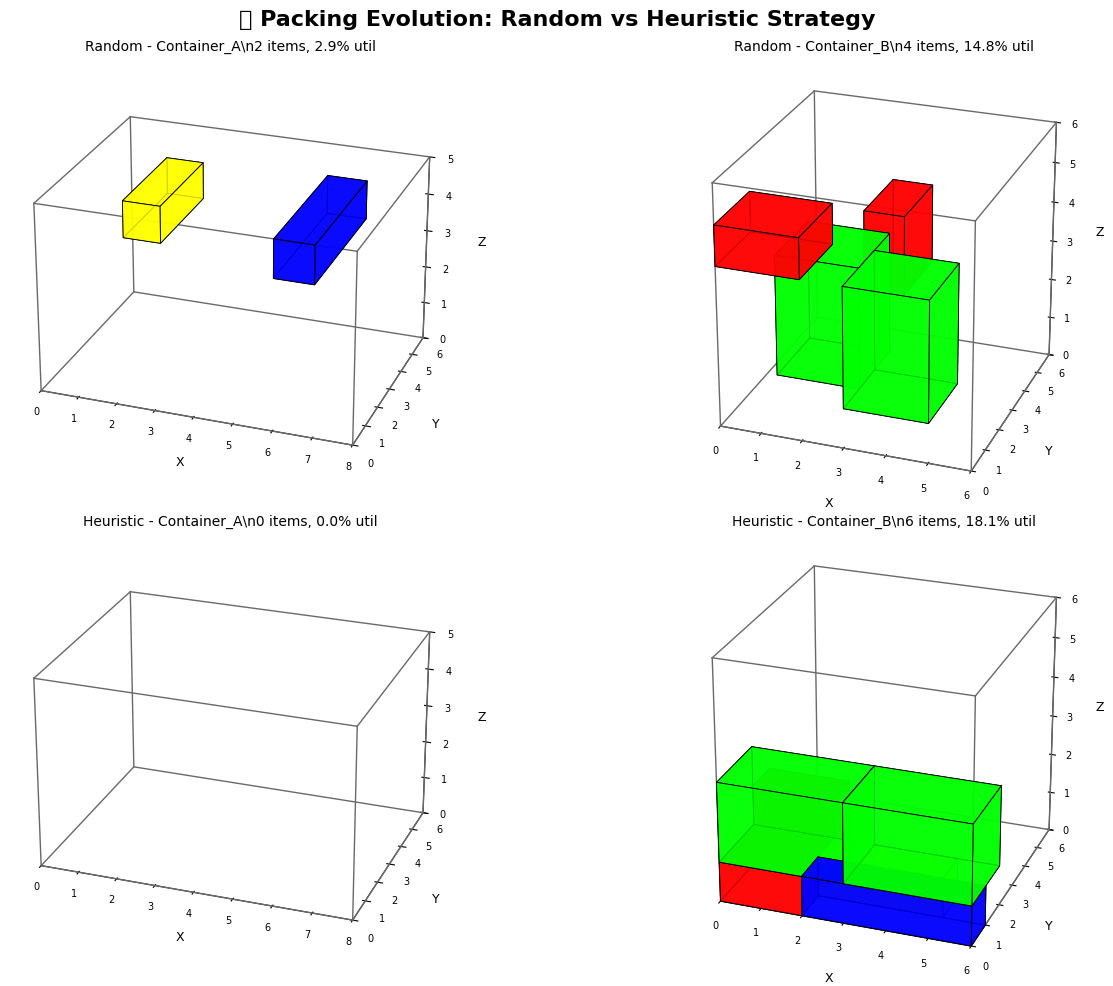

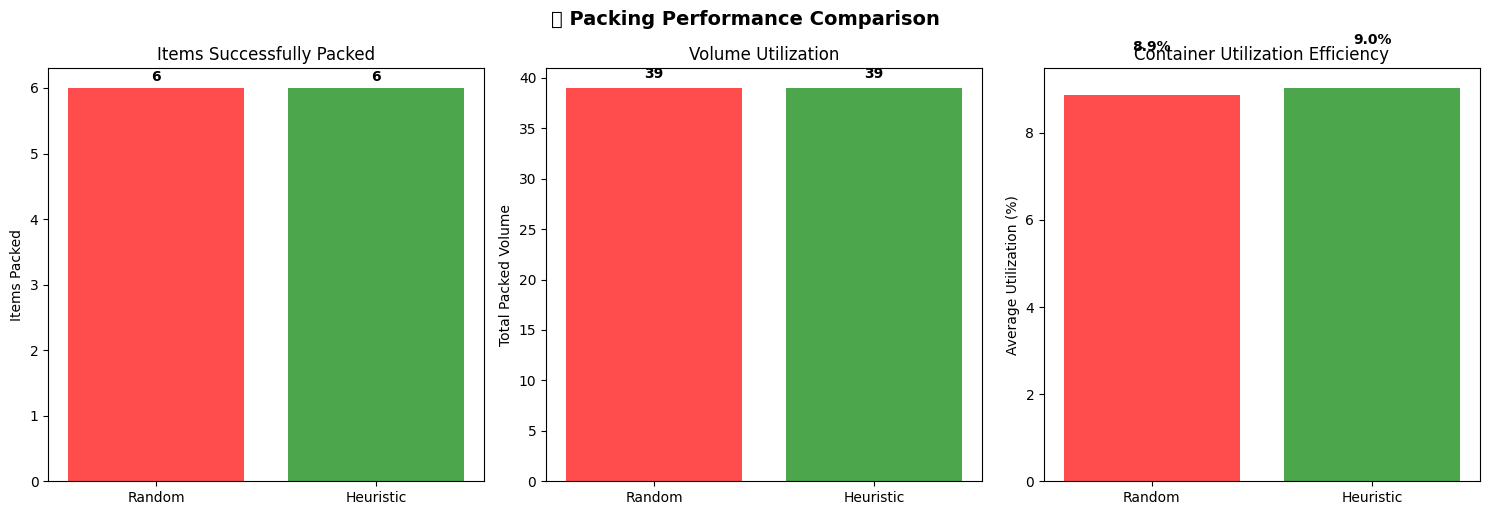

In [24]:
# 📦 Create Environments and Agents
env_random = PackingEnv(
    container_schemas=CONTAINER_SCHEMAS,
    item_definitions=ITEM_DEFINITIONS,
    item_sequence_names=ITEM_SEQUENCE
)

env_heuristic = PackingEnv(
    container_schemas=CONTAINER_SCHEMAS,
    item_definitions=ITEM_DEFINITIONS,
    item_sequence_names=ITEM_SEQUENCE
)

print(f"3D Packing Environment:")
print(f"  Containers: {len(CONTAINER_SCHEMAS)}")
print(f"  Items to pack: {len(ITEM_SEQUENCE)}")
print(f"  Container schemas: {[c['id'] + str(c['dims']) for c in CONTAINER_SCHEMAS]}")

# 📦 Create Agents
random_agent = RandomAgent()
heuristic_agent = HeuristicAgent()

print("\\n🎯 Running single episode comparison...")

# Test both agents
print("Testing random packing agent...")
random_result = run_agent_episode(random_agent, "Random", env_random)

print("Testing heuristic packing agent...")
heuristic_result = run_agent_episode(heuristic_agent, "Heuristic", env_heuristic)

# Show results
print(f"\\n📊 SINGLE EPISODE RESULTS:")
print(f"Random Agent:    {random_result['packed_items']} items, {random_result['packed_volume']:.0f} vol, {random_result['avg_utilization']:.1f}% avg util")
print(f"Heuristic Agent: {heuristic_result['packed_items']} items, {heuristic_result['packed_volume']:.0f} vol, {heuristic_result['avg_utilization']:.1f}% avg util")

# Create visualization
create_comparison_visualization(random_result, heuristic_result, env_random, env_heuristic)
plt.show()

# Performance comparison chart
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

agents = ['Random', 'Heuristic']
colors = ['red', 'green']

# Items packed comparison
items_packed = [random_result['packed_items'], heuristic_result['packed_items']]
bars1 = ax1.bar(agents, items_packed, color=colors, alpha=0.7)
ax1.set_ylabel('Items Packed')
ax1.set_title('Items Successfully Packed')
for bar, items in zip(bars1, items_packed):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{items}', ha='center', fontweight='bold')

# Volume utilization comparison
volumes = [random_result['packed_volume'], heuristic_result['packed_volume']]
bars2 = ax2.bar(agents, volumes, color=colors, alpha=0.7)
ax2.set_ylabel('Total Packed Volume')
ax2.set_title('Volume Utilization')
for bar, vol in zip(bars2, volumes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{vol:.0f}', ha='center', fontweight='bold')

# Average utilization percentage
avg_utils = [random_result['avg_utilization'], heuristic_result['avg_utilization']]
bars3 = ax3.bar(agents, avg_utils, color=colors, alpha=0.7)
ax3.set_ylabel('Average Utilization (%)')
ax3.set_title('Container Utilization Efficiency')
for bar, util in zip(bars3, avg_utils):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{util:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.suptitle('📈 Packing Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.show()


\n🔄 Running multiple episodes to show consistency...
Run 1/5...
Run 2/5...
Run 3/5...
Run 4/5...
Run 5/5...
\n📊 EVOLUTION SUMMARY (5 runs):
Random Agent:    6.0 avg items, 39 avg volume, 8.5% avg util
Heuristic Agent: 6.0 avg items, 39 avg volume, 9.0% avg util
\n🚀 Improvement: 0% more items, 0% more volume, +0.5% utilization!


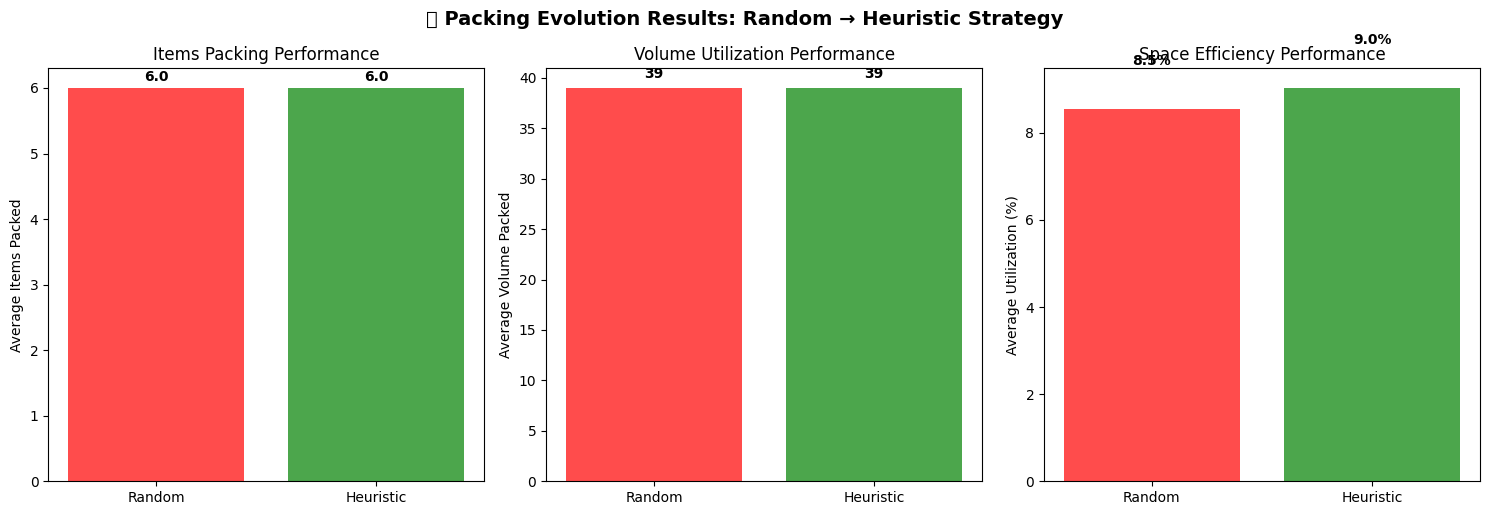

In [25]:
# 📈 Multiple Runs Analysis
print("\\n🔄 Running multiple episodes to show consistency...")

random_items = []
heuristic_items = []
random_volumes = []
heuristic_volumes = []
random_utils = []
heuristic_utils = []

NUM_RUNS = 5

for run in range(NUM_RUNS):
    print(f"Run {run + 1}/{NUM_RUNS}...")
    
    # Random agent
    env_random_run = PackingEnv(CONTAINER_SCHEMAS, ITEM_DEFINITIONS, ITEM_SEQUENCE)
    random_result = run_agent_episode(random_agent, "Random", env_random_run)
    random_items.append(random_result['packed_items'])
    random_volumes.append(random_result['packed_volume'])
    random_utils.append(random_result['avg_utilization'])
    
    # Heuristic agent
    env_heuristic_run = PackingEnv(CONTAINER_SCHEMAS, ITEM_DEFINITIONS, ITEM_SEQUENCE)
    heuristic_result = run_agent_episode(heuristic_agent, "Heuristic", env_heuristic_run)
    heuristic_items.append(heuristic_result['packed_items'])
    heuristic_volumes.append(heuristic_result['packed_volume'])
    heuristic_utils.append(heuristic_result['avg_utilization'])

print(f"\\n📊 EVOLUTION SUMMARY ({NUM_RUNS} runs):")
print(f"Random Agent:    {np.mean(random_items):.1f} avg items, {np.mean(random_volumes):.0f} avg volume, {np.mean(random_utils):.1f}% avg util")
print(f"Heuristic Agent: {np.mean(heuristic_items):.1f} avg items, {np.mean(heuristic_volumes):.0f} avg volume, {np.mean(heuristic_utils):.1f}% avg util")

# Calculate improvements
if np.mean(random_items) > 0:
    items_improvement = ((np.mean(heuristic_items) - np.mean(random_items)) / np.mean(random_items)) * 100
    volume_improvement = ((np.mean(heuristic_volumes) - np.mean(random_volumes)) / np.mean(random_volumes)) * 100
    util_improvement = np.mean(heuristic_utils) - np.mean(random_utils)
    
    print(f"\\n🚀 Improvement: {items_improvement:.0f}% more items, {volume_improvement:.0f}% more volume, +{util_improvement:.1f}% utilization!")

# Final comparison visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

agents = ['Random', 'Heuristic']
colors = ['red', 'green']

# Average items packed
avg_items = [np.mean(random_items), np.mean(heuristic_items)]
bars1 = ax1.bar(agents, avg_items, color=colors, alpha=0.7)
ax1.set_ylabel('Average Items Packed')
ax1.set_title('Items Packing Performance')
for bar, items in zip(bars1, avg_items):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{items:.1f}', ha='center', fontweight='bold')

# Average volume
avg_volumes = [np.mean(random_volumes), np.mean(heuristic_volumes)]
bars2 = ax2.bar(agents, avg_volumes, color=colors, alpha=0.7)
ax2.set_ylabel('Average Volume Packed')
ax2.set_title('Volume Utilization Performance')
for bar, vol in zip(bars2, avg_volumes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{vol:.0f}', ha='center', fontweight='bold')

# Average utilization
avg_utilizations = [np.mean(random_utils), np.mean(heuristic_utils)]
bars3 = ax3.bar(agents, avg_utilizations, color=colors, alpha=0.7)
ax3.set_ylabel('Average Utilization (%)')
ax3.set_title('Space Efficiency Performance')
for bar, util in zip(bars3, avg_utilizations):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{util:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.suptitle('📊 Packing Evolution Results: Random → Heuristic Strategy', fontsize=14, fontweight='bold', y=1.02)
plt.show()
